In [2]:
import pickle
import pandas as pd
from connections import AWS

In [3]:
""" CREATE AWS CONNECTION """
aws_connection = AWS()
aws_connection.connect()

[AWS]: Port 5433 is free.
[AWS]: Connected to RDS endpoint.


$\textbf{Newton Euler QA: Motion Plots}$

In [4]:
# get all trial motion files
s3_objects_all = aws_connection.list_s3_objects(prefix='biomechanics/subjects/')
s3_motion_files = [obj for obj in s3_objects_all if obj.endswith('.pkl') and 'motion_dict' in obj]

In [45]:
# iterate through and read files
ulna_data = []
for f in s3_motion_files:
    obj = aws_connection.s3.get_object(
        Bucket=aws_connection.bucket_name,
        Key=f
    )
    body_bytes = obj['Body'].read()
    motion_dict = pickle.loads(body_bytes)

    # extract ulna data
    trial_name = f.split('/')[-1].split('_motion')[0]
    if 'ulna_r' in motion_dict['body'].keys():
        ulna_ang_velo = motion_dict['body']['ulna_r']['angular_velocity_in_body'].T
    else:
        ulna_ang_velo = motion_dict['body']['ulna_l']['angular_velocity_in_body'].T
        
    # create dataframe    
    ulna_df = pd.DataFrame(ulna_ang_velo, columns=['x', 'y', 'z'])
    ulna_df.insert(0, 'study_id', trial_name)

    # normalize time
    ulna_df['norm_time'] = ulna_df.index / (len(ulna_df) - 1)

    # append to list
    ulna_data.append(ulna_df)

# concatenate all dataframes
ulna_data_full = pd.concat(ulna_data, ignore_index=True)

$\textbf{Spaghetti Plots}$

- Ulna angular velocity in body (x/y/z)
- Others TBD

In [8]:
import matplotlib.pyplot as plt

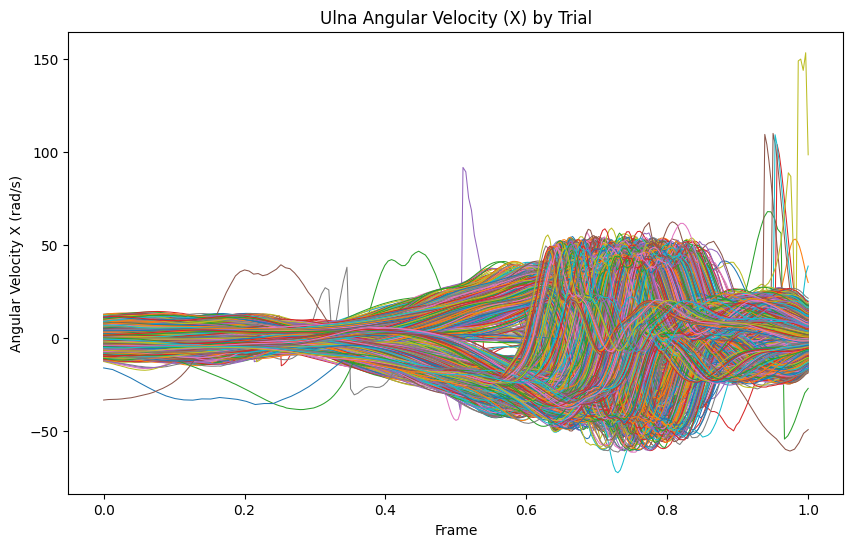

In [54]:
plt.figure(figsize=(10, 6))
for study_id, group in ulna_data_full.groupby('study_id'):
    plt.plot(group['norm_time'], group['x'], label=study_id, linewidth=0.75)

plt.xlabel('Frame')
plt.ylabel('Angular Velocity X (rad/s)')
plt.title('Ulna Angular Velocity (X) by Trial')
plt.show()

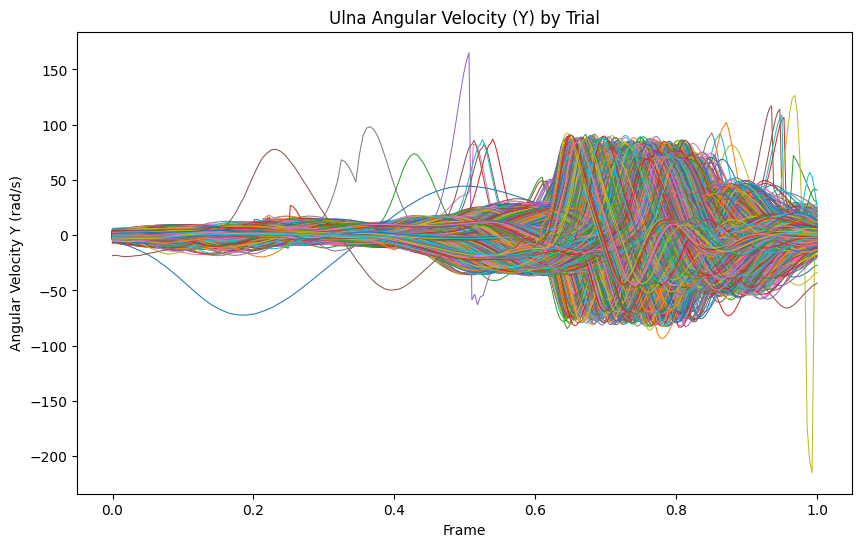

In [55]:
plt.figure(figsize=(10, 6))
for study_id, group in ulna_data_full.groupby('study_id'):
    plt.plot(group['norm_time'], group['y'], label=study_id, linewidth=0.75)

plt.xlabel('Frame')
plt.ylabel('Angular Velocity Y (rad/s)')
plt.title('Ulna Angular Velocity (Y) by Trial')
plt.show()

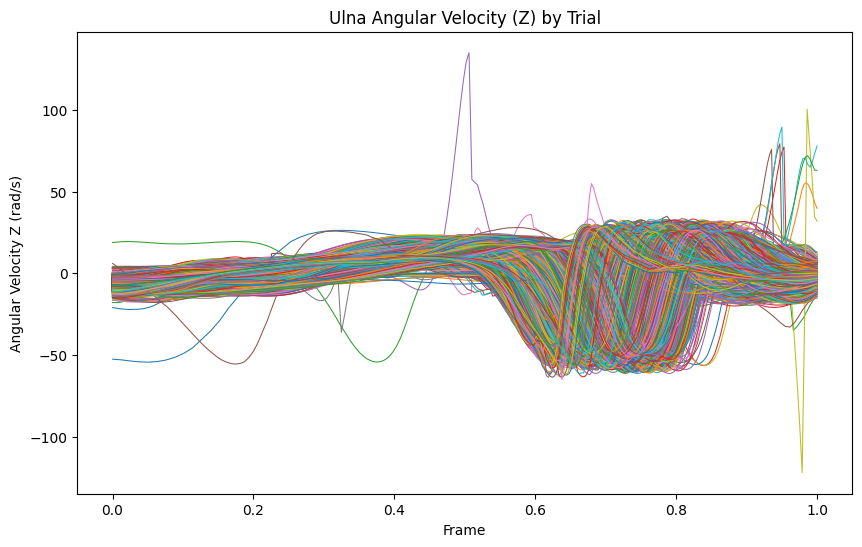

In [56]:
plt.figure(figsize=(10, 6))
for study_id, group in ulna_data_full.groupby('study_id'):
    plt.plot(group['norm_time'], group['z'], label=study_id, linewidth=0.75)

plt.xlabel('Frame')
plt.ylabel('Angular Velocity Z (rad/s)')
plt.title('Ulna Angular Velocity (Z) by Trial')
plt.show()

$\textit{Elbow Valgus Torque}$

In [6]:
# iterate through and read files
elbow_data = []
for f in s3_motion_files:
    obj = aws_connection.s3.get_object(
        Bucket=aws_connection.bucket_name,
        Key=f
    )
    body_bytes = obj['Body'].read()
    motion_dict = pickle.loads(body_bytes)

    # extract elbow data
    trial_name = f.split('/')[-1].split('_motion')[0]
    if 'elbow_r' in motion_dict['joint'].keys():
        elbow_torque = motion_dict['joint']['elbow_r']['intersegmental_moment'].T
    else:
        elbow_torque = motion_dict['joint']['elbow_l']['intersegmental_moment'].T
        
    # create dataframe    
    elbow_df = pd.DataFrame(elbow_torque, columns=['x', 'y', 'z'])
    elbow_df.insert(0, 'study_id', trial_name)

    # normalize time
    elbow_df['norm_time'] = elbow_df.index / (len(elbow_df) - 1)

    # append to list
    elbow_data.append(elbow_df)

# concatenate all dataframes
elbow_data_full = pd.concat(elbow_data, ignore_index=True)

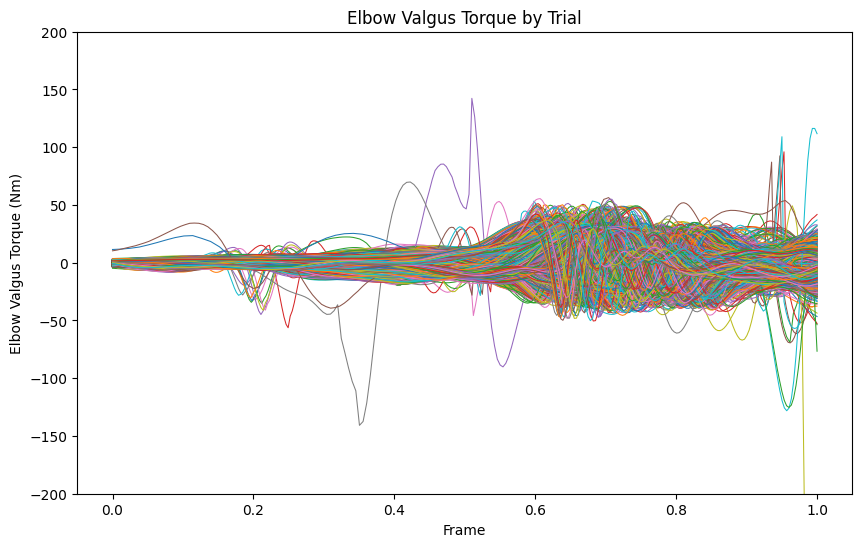

In [11]:
plt.figure(figsize=(10, 6))
for study_id, group in elbow_data_full.groupby('study_id'):
    plt.plot(group['norm_time'], group['x'], label=study_id, linewidth=0.75)

plt.ylim(-200, 200)
plt.xlabel('Frame')
plt.ylabel('Elbow Valgus Torque (Nm)')
plt.title('Elbow Valgus Torque by Trial')
plt.show()

$\textbf{Close Connection}$

In [24]:
aws_connection.close()

[AWS]: Database connection closed.
[AWS]: SSH tunnel stopped.
